<h1><center>Лабораторна робота 3.</center></h1>
<h2><center>Задача класифікації за набором даних Adult репозитарію UCI</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

<a class="anchor" id="3"></a>

## Зміст

1. [Синтетичний набір даних "дівчина в барі"](#3.1)
2. [Функції для обрахування ентропії й приросту інформації](#3.2)
3. [Задача класифікації за набором данних "Adult"](#3.3)
    - [Модель дерева рішень без налаштування параметрів](#3.3.1)
    - [Модель найближчих сусідів без налаштування параметрів](#3.3.2)
    - [Машинне моделювання з налаштуванням параметрів](#3.3.3)

У цій лабораторній роботі Вам пропонується розібратися з тим, як працює дерево рішень на іграшковому прикладі. Ми навчимо і налаштуємо дерево рішень і (за бажанням) випадковий ліс для задачі класифікації за уже знайомим набором даних Adult сховища UCI.

Спершу підключаємо необхідні бібліотеки:

In [1]:
# Відключимо різні попередження Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
# задамо графіки у форматі .svg, щоби вони мали кращу чіткість
%config InlineBackend.figure_format = 'svg' 

# підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5
plt.gcf().set_dpi(100);

<Figure size 700x500 with 0 Axes>

<a class="anchor" id="3.1"></a>

## <span style="color:blue; font-size:1.2em;">3.1. Синтетичний набір даних "дівчина в барі"</span>

[Повернутися до змісту](#3)

Мета цієї частини - "на пальцях", за допомогою іграшкової задачі класифікації розібратися в тому, як працюють дерева рішень. Саме по собі дерево рішень є доволі слабким алгоритмом, але основані на ньому алгоритми випадкового лісу і градієнтного бустингу - мабуть, найкращі рішення, що є на сьогодні (в задачах, де можна обійтися без нейронних мереж). Тому розібратися в тому, як працює дерево рішень, доволі корисно.

Спершу розглянемо таку задачу бінарної класифікації: чи поїде з Вами дівчина з бару випити філіжанку кави? Результат цієї задачі залежатиме від таких чинників: Ваша зовнішність і внутрішня харизма, міцність запропонованих напоїв і, як би це не звучало меркантильно, від кількості витрачених в барі грошей.

### Створення набору даних

In [3]:
# Створення датафрейму з dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Зовнішність', 'Алкоголь_в_напої',
            'Рівень_харизми', 'Витрачені_гроші']

Задамо навчальну вибірку:

In [5]:
df_train = {'Зовнішність': ['приємна', 'приємна', 'приємна', 'відштовхуюча',
                            'відштовхуюча', 'відштовхуюча', 'приємна'],
            'Алкоголь_в_напої': ['так', 'так', 'ні', 'ні', 'так', 'так', 'так'],
            'Рівень_харизми': ['високий', 'низький', 'середній', 'середній', 'низький',
                               'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато', 'мало', 'багато',
                                                                           'багато', 'багато'],
            'Поїде': LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])}

df_train = create_df(df_train, features)
df_train

,Поїде,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_низький,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,0,False,True,False,True,True,False,False,True,False
1,1,False,True,False,True,False,True,False,False,True
2,0,False,True,True,False,False,False,True,True,False
3,1,True,False,True,False,False,False,True,False,True
4,1,True,False,False,True,False,True,False,True,False
5,0,True,False,False,True,True,False,False,True,False
6,0,False,True,False,True,False,False,True,True,False


Задамо тестову вибірку:

In [6]:
df_test = {'Зовнішність': ['приємна', 'приємна', 'відштовхуюча'], 'Алкоголь_в_напої': ['ні', 'так', 'так'],
           'Рівень_харизми': ['середній', 'високий', 'середній'], 'Витрачені_гроші': ['багато', 'мало', 'багато']}
df_test = create_df(df_test, features)
df_test

,Зовнішність_відштовхуюча,Зовнішність_приємна,Алкоголь_в_напої_ні,Алкоголь_в_напої_так,Рівень_харизми_високий,Рівень_харизми_середній,Витрачені_гроші_багато,Витрачені_гроші_мало
0,False,True,True,False,False,True,True,False
1,False,True,False,True,True,False,False,True
2,True,False,False,True,False,True,True,False


In [7]:
# Деякі значення ознак є в тестовій підвибірці, але немає в навчальній і навпаки
y = df_train['Поїде']

In [8]:
df_train_inter, df_test_inter = intersect_features(train=df_train, test=df_test)

In [9]:
df_train_inter

,Рівень_харизми_високий,Витрачені_гроші_багато,Зовнішність_відштовхуюча,Алкоголь_в_напої_так,Витрачені_гроші_мало,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні
0,True,True,False,True,False,False,True,False
1,False,False,False,True,True,False,True,False
2,False,True,False,False,False,True,True,True
3,False,False,True,False,True,True,False,True
4,False,True,True,True,False,False,False,False
5,True,True,True,True,False,False,False,False
6,False,True,False,True,False,True,True,False


In [10]:
df_test_inter

,Рівень_харизми_високий,Витрачені_гроші_багато,Зовнішність_відштовхуюча,Алкоголь_в_напої_так,Витрачені_гроші_мало,Рівень_харизми_середній,Зовнішність_приємна,Алкоголь_в_напої_ні
0,False,True,False,False,False,True,True,True
1,True,False,False,True,True,False,True,False
2,False,True,True,True,False,True,False,False


Дайте відповідь на запитання нижче.

<span style="color:red; font-size:2em;">Завдання 1</span>

---

**Варіант 1:** Обчисліть ентропію системи після поділу на групи за ознакою `Алкоголь_в_напої`. Для правильного виконання завдання розрахунок потрібно виконати через написання програмного коду на Python на основі відповідних математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 2:** Розрахуйте приріст інформації за розбиття системи за ознакою `Рівень_харизми`. Для правильного виконання завдання використайте програмний код на Python, спираючись на математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 3:** Використайте ознаку `Зовнішність`, щоб обчислити приріст інформації для прогнозування ознаки `Поїде`. Для точного розрахунку використайте Python і математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 4:** Виконайте розрахунок приросту інформації за ознакою `Витрачені_гроші` для бінарної класифікації. Для правильного виконання завдання скористайтесь кодом на Python та математичними формулами з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 5:** Розрахуйте зміну ентропії після поділу на групи за кількістю випитого алкоголю та обчисліть приріст інформації. Для правильного розрахунку напишіть програмний код на Python та використайте математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 6:** Обчисліть, чи можна отримати приріст інформації, якщо використати ознаку `Рівень_харизми` для першого розбиття. Для цього використайте Python та математичні формули з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 7:** Розрахуйте приріст інформації для ознаки `Зовнішність` та порівняйте його з іншими ознаками. Виконайте ці обчислення програмно на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 8:** Використайте ознаку `Алкоголь_в_напої` для розбиття вибірки та розрахуйте приріст інформації. Для правильного виконання завдання напишіть програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 9:** Обчисліть, який приріст інформації дасть ознака `Зовнішність` для прогнозування `Поїде`. Для правильного виконання завдання скористайтесь Python та математичними формулами з лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 10:** Розрахуйте ентропію системи після поділу на групи за ознакою `Рівень_харизми` та визначте приріст інформації. Виконайте завдання через написання коду на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 11:** Обчисліть, яке розбиття на основі ознаки `Витрачені_гроші` дасть максимальний приріст інформації. Реалізуйте це через Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 12:** Виконайте розрахунок ентропії системи після поділу на основі ознаки `Алкоголь_в_напої`. Розрахунок приріст інформації виконайте за допомогою Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 13:** Обчисліть, яким є приріст інформації за ознакою `Зовнішність` порівняно з ознакою `Рівень_харизми`. Для правильного виконання розрахунку використайте програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 14:** Розрахуйте, чи призведе використання ознаки `Алкоголь_в_напої` до більшого приросту інформації, ніж `Рівень_харизми`. Виконайте це на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 15:** Обчисліть приріст інформації після першого розбиття за ознакою `Зовнішність`. Для правильного виконання завдання напишіть програмний код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 16:** Розрахуйте приріст інформації за ознакою `Витрачені_гроші`. Для правильного виконання завдання напишіть код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 17:** Обчисліть, який приріст інформації буде після поділу вибірки на основі ознаки `Алкоголь_в_напої`. Виконайте це завдання на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 18:** Розрахуйте, який приріст інформації забезпечить ознака `Рівень_харизми` при поділі вибірки. Напишіть відповідний код на Python з використанням математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 19:** Обчисліть, яка ознака дасть найбільший приріст інформації для класифікації, використовуючи ознаку `Алкоголь_в_напої`. Для цього використайте програмний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

---

**Варіант 20:** Розрахуйте приріст інформації для ознаки `Зовнішність` і порівняйте його з приріст інформації для `Рівень_харизми`. Напишіть відповідний код на Python на основі математичних формул із лекційної записки 3. Побудуйте за допомогою `sklearn` дерево рішень за навчальною вибіркою `df_train_inter`. Глибину дерева можна не обмежувати. Відобразіть дерево за допомогою `graphviz` бібліотеки `pydotplus`.

<a class="anchor" id="3.2"></a>

## <span style="color:blue; font-size:1.2em;">3.2. Функції для обрахування ентропії й приросту інформації</span>

[Повернутися до змісту](#3)

**Приклад для перевірки:** 9 синіх кульок і 11 жовтих. Нехай кулька перебуває в стані "1", якщо вона синя і "0", якщо – жовта.

In [11]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_1.png)

Далі нехай кульки розбиваються на 2 групи:

![img](https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/3_decision-tree_circles_2.png)

In [12]:
# Створіть дві групи кульок (приберіть pass)
# Передайте нові значення в змінні balls_left та balls_right
balls_left  = None # 8 синіх і 5 жовтих
balls_right = None # 1 синя і 6 жовтих

Реалізуйте функцію для обрахування ентропії Шеннона:

Перевіряємо працездатність функції `entropy`:

In [13]:
def entropy(a_list):
    ''' Функція для обчислення ентропії'''
    # Ваш код тут
    
    pass

In [14]:
# обрахунок приросту інформації

def information_gain(root, left, right):
    ''' Функція для обчислення приросту інформації.
    Root - початковий набір даних, left і right два розбиття початкового набору '''
    
    # Ваш код тут
    
    pass

<span style="color:red; font-size:2em;">Завдання 2</span>

---

**Варіант 1:** Обчисліть ентропію вибірки `balls`, використовуючи самостійну реалізацію функції `def entropy(a_list):` на основі математичних формул із лекційної записки 3. Поділ кульок мусить відбуватися за ознакою `координата X <= 12`.

---

**Варіант 2:** Виконайте поділ вибірки `balls_left` на дві підгрупи за умовою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 3:** Розробіть функцію `def entropy(a_list):` для обчислення ентропії масиву ймовірностей випадкових подій. Застосуйте її до списку `balls_right`, поділивши кульки за ознакою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 4:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення приросту інформації за поділу вибірки `balls_left` за ознакою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 5:** Обчисліть ентропію вибірки `balls_right`, використовуючи функцію `def entropy(a_list):`, а потім визначте приріст інформації за допомогою функції `def information_gain(root, left, right):` після поділу на групи за умовою `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 6:** Використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`, розрахуйте приріст інформації за поділу вибірки `balls` на основі ознаки `координата X <= 12`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 7:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення приросту інформації за поділу вибірки `balls_left` за умовою `координата X <= 12`. Використайте відповідні математичні формули з лекційної записки 3.

---

**Варіант 8:** Виконайте поділ вибірки `balls_right` за ознакою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 9:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення ентропії після поділу вибірки `balls_left` за умовою `координата X <= 12`. Виконайте розрахунок приросту інформації за математичними формулами із лекційної записки 3.

---

**Варіант 10:** Обчисліть ентропію вибірки `balls`, використовуючи функцію `def entropy(a_list):`, після поділу кульок за ознакою `координата X <= 12`. Застосуйте функцію `def information_gain(root, left, right):` до обчислення приросту інформації. Використайте математичні формули із лекційної записки 3.

---

**Варіант 11:** Виконайте аналіз приросту інформації для вибірки `balls_right`, поділивши її за умовою `координата X <= 12`. Обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 12:** Напишіть функції `def entropy(a_list):` та `def information_gain(root, left, right):` для обчислення ентропії після поділу вибірки `balls_left` за умовою `координата X <= 12`. Визначте приріст інформації на основі математичних формул із лекційної записки 3.

---

**Варіант 13:** Розробіть алгоритм поділу вибірки `balls` на категорії за умовою `координата X <= 12` і обчисліть приріст інформації, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 14:** Обчисліть приріст інформації для вибірки `balls_left`, поділивши її за умовою `координата X <= 12`, використовуючи функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 15:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділивши її за умовою `координата X <= 12`. Реалізуйте обчислення за допомогою функцій `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 16:** Створіть функцію `def entropy(a_list):` для обчислення ентропії після поділу вибірки `balls` за умовою `координата X <= 12`, а також функцію `def information_gain(root, left, right):` для обчислення приросту інформації. Використайте математичні формули із лекційної записки 3.

---

**Варіант 17:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділеної за умовою `координата X <= 12`. Для обчислень використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` та математичні формули із лекційної записки 3.

---

**Варіант 18:** Обчисліть приріст інформації для вибірки `balls_left`, поділивши її за умовою `координата X <= 12`. Використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` та математичні формули із лекційної записки 3.

---

**Варіант 19:** Напишіть програму Python для обчислення ентропії та приросту інформації за поділу вибірки `balls` за умовою `координата X <= 12`. Реалізуйте обчислення через функції `def entropy(a_list):` та `def information_gain(root, left, right):`. Використайте математичні формули із лекційної записки 3.

---

**Варіант 20:** Виконайте розрахунок приросту інформації для вибірки `balls_right`, поділеної за умовою `координата X <= 12`. Використайте функції `def entropy(a_list):` та `def information_gain(root, left, right):` для аналізу зміни ентропії за математичними формулами із лекційної записки 3.

<a class="anchor" id="3.3"></a>

## <span style="color:blue; font-size:1.2em;">3.3. Задача класифікації за набором даних "Adult"</span>

[Повернутися до змісту](#3)

**Набір даних [UCI Adult](https://archive.ics.uci.edu/dataset/2/adult)** (додатково завантажувати не треба, всі дані є в репозитарії): класифікація людей за допомогою демографічних даних для прогнозування того, чи заробляє людина більше \$ 50 000 в рік.

Опис ознак набору даних UCI Adult можете знайти в ноутбуці [лабораторної роботи №1](https://github.com/radiukpavlo/intelligent-data-analysis/blob/main/02_assignments/ida_lab-01_adult_pandas/ida_lab-01_adult_pandas.ipynb).

Завантажуємо навчальну та тестову вибірки.

In [15]:
data_train_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_train.csv'
data_train = pd.read_csv(data_train_url, sep=';')

data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [16]:
data_test_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-03_classification/adult_test.csv'
data_test = pd.read_csv(data_test_url, sep=';')

data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [17]:
# Необхідно видалити рядки з неправильними мітками в тестовій вибірці
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# Перекодуємо target в числове поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1


Первинний аналіз даних.

In [18]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_train['Target'].value_counts()

Target
0    24720
1     7841
Name: count, dtype: int64

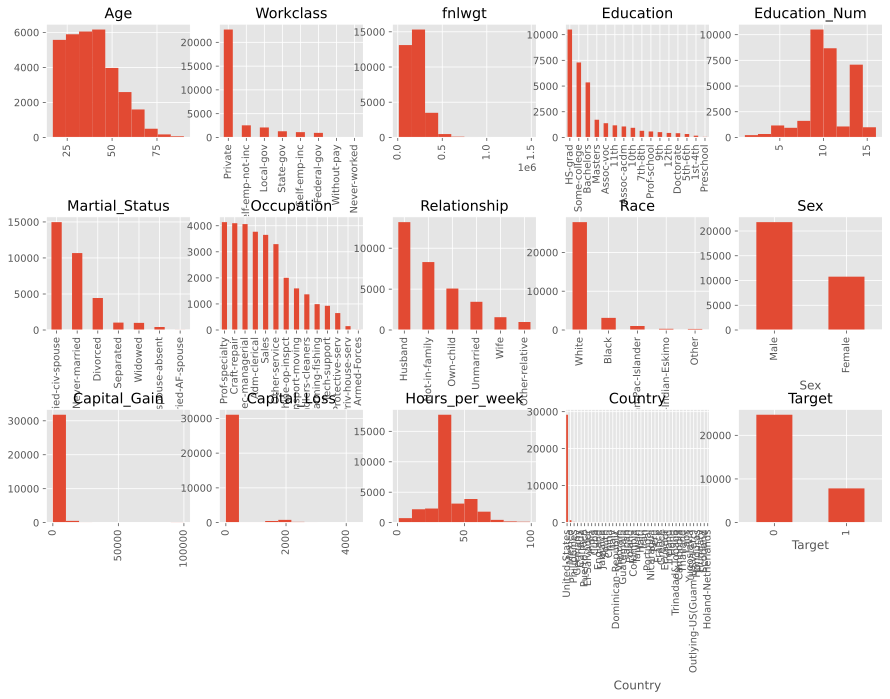

In [20]:
fig = plt.figure(figsize=(15, 9))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)


Перевіряємо типи даних.

In [21]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [22]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

З'ясувалося, що в тестовому наборі даних вік віднесений до типу object, необхідно це виправити.

In [23]:
data_test['Age'] = data_test['Age'].astype(int)

Також переведемо показники типу float в int для відповідності train і test вибірок.

In [24]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

Заповнимо пропуски в кількісних полях значеннями [медіан](https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D1%96%D0%B0%D0%BD%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0)), а в категоріальних - ті значення, що зустрічаються найчастіше ([мода](https://uk.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B0_(%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D0%BA%D0%B0))).

In [25]:
# виділимо у вибірках категоріальні і числові поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [26]:
# заповнюємо пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

Кодуємо категоріальні ознаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Це можна зробити за допомогою методу `pandas get_dummies`.

In [27]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [28]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [29]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281.0,NaN,NaN,NaN,38.767459,13.849187,17.0,28.0,37.0,48.0,90.0
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Capital_Gain,16281.0,NaN,NaN,NaN,1081.905104,7583.935968,0.0,0.0,0.0,0.0,99999.0
Capital_Loss,16281.0,NaN,NaN,NaN,87.899269,403.105286,0.0,0.0,0.0,0.0,3770.0
...,...,...,...,...,...,...,...,...,...,...,...
Country_ Thailand,16281,2,False,16269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Trinadad&Tobago,16281,2,False,16273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ United-States,16281,2,True,14662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country_ Vietnam,16281,2,False,16262,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [31]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

У тестовій вибірці не виявилося Нідерландів. Заведемо необхідну ознаку та заповнимо рядки нулями.

In [32]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [33]:
set(data_train.columns) - set(data_test.columns)

set()

In [34]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [35]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0
2,38,89814,9,0,0,50,0,False,False,False,...,False,False,False,False,False,False,True,False,False,0.0


In [36]:
# Переназначимо цільову ознаку 'Target'
# як окремий список міток для навчального та тестового наборів даних
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

# Подамо навчальні та тестові дані у вигляді матриць `dtype=np.float32`
X_train = X_train.values
X_test = X_test.values

<a class="anchor" id="3.3.1"></a>

### <span style="color:blue; font-size:1em;">3.3.1. Модель дерева рішень без налаштування параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 3</span>

---

**Для всіх варіантів:**  

- Використовувати `adult_train.csv` (розділювач `;`, `skipinitialspace=True`). Розділити дані на навчальну/тестову вибірки у співвідношенні 80/20 з `stratify=Target` та `random_state=17`.  
- Побудувати базову модель `DecisionTreeClassifier(max_depth=3, criterion='entropy', random_state=17)` у складі `Pipeline` з `OneHotEncoder(handle_unknown='ignore')`.  
- Для бази зафіксувати `accuracy`, `precision`, `recall`, `f1` для класу `>50K`, `balanced_accuracy`, `roc_auc` і матрицю помилок.  
- У кожному варіанті навчити рекомендовану модель, порівняти метрики з базою, проаналізувати різницю та прокоментувати інтерпретацію.

---

**Варіант 1 – Глибина 5 та великі листи:**  

- Мета: перевірити вплив збільшення глибини та розміру листів на стабільність моделі.  
- Кроки:  
  1. Навчити дерево з параметрами `max_depth=5`, `min_samples_leaf=100`, `criterion='entropy'`.  
  2. Порівняти accuracy, F1, balanced accuracy з базою.  
  3. Побудувати графік `feature_importances_` (топ-10 ознак).  
  4. Проаналізувати, чи зросла частка помилок другого роду (FN).  
- Підказки: сформувати `pd.Series(feature_importances_, index=feature_names)` для зручності.  
- Перевірка: додати таблицю з метриками та короткий висновок.

---

**Варіант 2 – Класові ваги balanced:**  

- Мета: оцінити, як `class_weight='balanced'` змінює поведінку дерева.  
- Кроки:  
  1. Використати параметри `max_depth=6`, `class_weight='balanced'`, `min_samples_split=200`.  
  2. Порівняти precision і recall для класу `>50K` з базою.  
  3. Оцінити, як змінилися ймовірності в листках (частка `>50K`).  
  4. Зробити висновок про ефективність балансування.  
- Підказки: застосувати `classification_report`.  
- Перевірка: навести таблицю метрик і відсоток записів у листках з домінуванням `>50K`.

---

**Варіант 3 – Обмеження ознак у вузлах:**  

- Мета: дослідити вплив `max_features='sqrt'`.  
- Кроки:  
  1. Навчити дерево з `max_depth=7`, `max_features='sqrt'`, `min_samples_leaf=80`.  
  2. Порівняти метрики та час навчання з базовою моделлю.  
  3. Визначити, які ознаки найчастіше з'являються у верхніх вузлах (`tree_.feature`).  
  4. Оцінити час прогнозування для 10 000 записів (`timeit`).  
- Підказки: отримати назви ознак допоможе `encoder.get_feature_names_out()`.  
- Перевірка: навести метрики й список 5 найчастіших ознак.

---

**Варіант 4 – Постпрунинг через ccp_alpha:**  

- Мета: застосувати мінімізацію вартості складності.  
- Кроки:  
  1. Побудувати дерево без обмежень глибини.  
  2. Отримати шлях обрізання (`cost_complexity_pruning_path`) і виконати крос-валідацію для добору `ccp_alpha`.  
  3. Донавчити дерево з оптимальним `ccp_alpha`.  
  4. Порівняти метрики й кількість листів з базою.  
- Підказки: використати `StratifiedKFold(n_splits=5)`.  
- Перевірка: навести вибране `ccp_alpha`, розмір дерева й точність.

---

**Варіант 5 – Тільки числові ознаки:**  

- Мета: оцінити можливості моделі без категоріальних ознак.  
- Кроки:  
  1. Відібрати числові ознаки (`Age`, `Education_Num`, `Capital_Gain`, `Capital_Loss`, `Hours_per_week`, `fnlwgt`).  
  2. Навчити дерево `max_depth=4`.  
  3. Порівняти accuracy, F1 та ROC-AUC із базою.  
  4. Проаналізувати важливості числових ознак.  
- Підказки: для AUC використати прогнозовані ймовірності.  
- Перевірка: навести таблицю метрик і графік важливостей.

---

**Варіант 6 – Пайплайн з нормалізацією:**  

- Мета: збудувати `Pipeline` з масштабуванням числових ознак.  
- Кроки:  
  1. Додати `StandardScaler` до числових колонок у `ColumnTransformer`.  
  2. Навчити дерево `max_depth=6`, `min_samples_leaf=120`.  
  3. Порівняти якість і кількість ознак після кодування з базою.  
  4. Зберегти пайплайн у файл `models/tree_pipeline.joblib`.  
- Підказки: протестувати `pipeline.predict` на одиничному прикладі.  
- Перевірка: навести метрики та підтвердження серіалізації.

---

**Варіант 7 – Навчання з вагами fnlwgt:**  

- Мета: врахувати ваги при навчанні дерева.  
- Кроки:  
  1. Нормалізувати `fnlwgt` (середня вага = 1).  
  2. Навчити дерево `max_depth=5` з `sample_weight`.  
  3. Порівняти метрики й важливості з невиваженим варіантом.  
  4. Проаналізувати зміни у розподілі листів.  
- Підказки: витягти ваги листів через `tree_.value`.  
- Перевірка: навести таблицю метрик і топ-5 важливостей.

---

**Варіант 8 – Ансамблювання трьох дерев:**  

- Мета: дослідити усереднення прогнозів глибоких дерев.  
- Кроки:  
  1. Навчити дерева з `max_depth=8/9/10`, `random_state=17/42/99`.  
  2. Отримати середній прогноз (усереднення ймовірностей).  
  3. Порівняти метрики окремих моделей та ансамблю з базою.  
  4. Оцінити варіативність F1.  
- Підказки: використати `np.mean` для ймовірностей.  
- Перевірка: навести таблицю метрик кожного дерева та ансамблю.

---

**Варіант 9 – Обмеження кількості листів:**  

- Мета: забезпечити інтерпретованість через `max_leaf_nodes=20`.  
- Кроки:  
  1. Навчити дерево з `max_leaf_nodes=20`, `min_samples_split=200`.  
  2. Створити текстове представлення дерева (`export_text`).  
  3. Порівняти метрики з базою.  
  4. Описати дві гілки з найбільшою кількістю записів.  
- Підказки: передати список назв ознак до `export_text`.  
- Перевірка: навести метрики та короткий опис гілок.

---

**Варіант 10 – Калібрування ймовірностей:**  

- Мета: оцінити потребу в калібруванні дерева.  
- Кроки:  
  1. Навчити дерево `max_depth=6`, `min_samples_leaf=80`.  
  2. Виконати калібрування через `CalibratedClassifierCV(method='isotonic')`.  
  3. Побудувати ROC-криві та обчислити Brier score до/після.  
  4. Порівняти F1 з базою.  
- Підказки: використати `roc_curve` та `calibration_curve`.  
- Перевірка: навести метрики до/після калібрування.

---

**Варіант 11 – Усунення мультиколінеарності числових ознак:**  

- Мета: прибрати числові ознаки з високим VIF перед навчанням.  
- Кроки:  
  1. Обчислити VIF для числових стовпців.  
  2. Видалити ознаки з VIF > 10.  
  3. Навчити дерево `max_depth=5`, `min_samples_split=150`.  
  4. Порівняти метрики та важливості з базою.  
- Підказки: скористатися `statsmodels.stats.outliers_influence.variance_inflation_factor`.  
- Перевірка: навести таблицю VIF і метрики моделі.

---

**Варіант 12 – Укрупнення категорій Country та Occupation:**  

- Мета: зменшити розмірність one-hot-кодування перед навчанням дерева.  
- Кроки:  
  1. Залишити топ-10 категорій у `Country` та `Occupation`, інші об'єднати у `'Other'`.  
  2. Навчити дерево `max_depth=6`, `min_samples_leaf=120`.  
  3. Порівняти метрики та кількість ознак після кодування з базою.  
  4. Оцінити зміну важливостей укрупнених ознак.  
- Підказки: використати `Series.where`.  
- Перевірка: навести таблицю метрик та графік важливостей.

---

**Варіант 13 – Чутливість до random_state:**  

- Мета: проаналізувати варіативність моделі залежно від `random_state`.  
- Кроки:  
  1. Навчити дерево `max_depth=6`, `min_samples_leaf=100` для 10 різних `random_state`.  
  2. Зібрати accuracy та F1 у DataFrame.  
  3. Побудувати boxplot для метрик.  
  4. Порівняти середнє, мінімум, максимум із базою.  
- Підказки: використати цикл і логер результатів.  
- Перевірка: навести статистики метрик.

---

**Варіант 14 – Помилки за регіонами:**  

- Мета: зрозуміти, у яких регіонах дерево `max_depth=5` найчастіше помиляється.  
- Кроки:  
  1. Навчити модель `max_depth=5`, `min_samples_split=150`.  
  2. Обчислити кількість FP/FN за регіонами (класифікація країн на 4 групи).  
  3. Порівняти з базою.  
  4. Сформулювати рекомендації для підвищення якості у проблемних регіонах.  
- Підказки: скористатися `pd.crosstab` для аналізу помилок.  
- Перевірка: надати таблицю помилок і висновок.

---

**Варіант 15 – Вплив undersampling:**  

- Мета: дослідити вплив випадкового undersampling більшості класу.  
- Кроки:  
  1. Застосувати `RandomUnderSampler` для досягнення балансу класів.  
  2. Навчити дерево `max_depth=6`, `min_samples_leaf=120`.  
  3. Порівняти метрики та важливості з повним набором.  
  4. Оцінити зміну recall для `>50K`.  
- Підказки: фіксувати `random_state` для відтворюваності.  
- Перевірка: навести метрики до/після та зміну recall.

---

**Варіант 16 – Глибина 9 і великі min_samples_split:**  

- Мета: знайти компроміс між глибиною й розміром підвибірки.  
- Кроки:  
  1. Навчити дерево `max_depth=9`, `min_samples_split=500`, `min_samples_leaf=120`.  
  2. Порівняти метрики та кількість листів із базою.  
  3. Виміряти середню глибину дерева (`tree_.max_depth`).  
  4. Зробити висновок щодо стабільності.  
- Підказки: для кількості листів використати `tree_.n_leaves`.  
- Перевірка: навести метрики, кількість листів і середню глибину.

---

**Варіант 17 – 10-кратна крос-валідація:**  

- Мета: оцінити стабільність моделі на 10 фолдах.  
- Кроки:  
  1. Створити пайплайн з деревом `max_depth=6`, `min_samples_leaf=150`.  
  2. Використати `cross_validate` з метриками `accuracy`, `f1`, `roc_auc`, `balanced_accuracy`.  
  3. Порівняти середні та стандартні відхилення з 5-фолдним результатом бази.  
  4. Зробити висновок про стабільність.  
- Підказки: увімкнути `return_train_score=True`.  
- Перевірка: навести зведену таблицю метрик.

---

**Варіант 18 – Порівняння з LightGBM:**  

- Мета: оцінити, наскільки класичне дерево поступається градієнтному бустингу.  
- Кроки:  
  1. Навчити дерево `max_depth=5`, `min_samples_leaf=120`.  
  2. Навчити `LGBMClassifier(random_state=17)` на тих самих ознаках.  
  3. Порівняти метрики й час навчання двох моделей.  
  4. Зробити висновок про баланс якості та інтерпретованості.  
- Підказки: для вимірювання часу використовувати `time.perf_counter`.  
- Перевірка: навести таблицю метрик і час навчання.

---

**Варіант 19 – Фільтрація за Hours_per_week:**  

- Мета: перевірити вплив виключення записів з <20 годин роботи на тиждень.  
- Кроки:  
  1. Побудувати дві моделі: на повній вибірці та на підмножині `Hours_per_week >= 20`.  
  2. Для обох варіантів навчити дерево `max_depth=6`, `min_samples_leaf=100`.  
  3. Порівняти метрики та структуру дерев.  
  4. Зробити висновок про вплив фільтрації.  
- Підказки: використовувати однаковий `random_state`.  
- Перевірка: навести метрики для обох моделей та ключові відмінності.

---

**Варіант 20 – Аналіз шляхів рішення:**  

- Мета: пояснити рішення моделі на конкретних прикладах.  
- Кроки:  
  1. Навчити дерево `max_depth=6`, `min_samples_leaf=100`.  
  2. Обрати три спостереження (правильний позитив, правильний негатив, помилковий негатив).  
  3. Вивести їхні decision path та перетворити на послідовність правил (наприклад, через `export_text`).  
  4. Пояснити причину помилки на негативному прикладі й запропонувати спосіб її уникнути.  
- Підказки: `decision_path` повертає розріджену матрицю – перетворити її у список індексів.  
- Перевірка: навести три описи шляхів та висновок.

<a class="anchor" id="3.3.2"></a>

### <span style="color:blue; font-size:1em;">3.3.2. Модель найближчих сусідів без налаштування параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 4</span>

---

**Для всіх варіантів:**  

- Використовувати той самий train/test поділ (80/20, `stratify=Target`, `random_state=17`). Побудувати `ColumnTransformer`: `StandardScaler` для числових ознак (`Age`, `Education_Num`, `Capital_Gain`, `Capital_Loss`, `Hours_per_week`, `fnlwgt`) і `OneHotEncoder(handle_unknown='ignore')` для категоріальних.  
- Базова модель: `KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='minkowski', p=2, leaf_size=10)`. Зафіксувати accuracy, precision, recall, F1 для класу `>50K`, balanced accuracy, ROC-AUC і матрицю помилок.  
- У кожному варіанті навчити зазначену конфігурацію, порівняти результати з базою, навести графіки/таблиці, зробити висновок про поведінку KNN.

---

**Варіант 1 – n_neighbors=5, uniform:**  

- Мета: дослідити вплив збільшення числа сусідів на точність і дисперсію моделі.  
- Кроки:  
  1. Навчити KNN з `n_neighbors=5`, `weights='uniform'`, `metric='euclidean'`.  
  2. Порівняти accuracy, F1, ROC-AUC із базою.  
  3. Побудувати learning curve (5 точок від 10% до 100% train).  
  4. Проаналізувати, чи зменшилась дисперсія метрик.  
- Підказки: скористатися `learning_curve`.  
- Перевірка: навести таблицю метрик і графік learning curve.

---

**Варіант 2 – weights='distance', n_neighbors=7:**  

- Мета: оцінити вплив інверсно-відстаневих ваг.  
- Кроки:  
  1. Навчити модель з `n_neighbors=7`, `weights='distance'`.  
  2. Порівняти precision, recall, F1 з базою.  
  3. Оцінити середні та медіанні відстані до 7 сусідів (через `kneighbors`).  
  4. Зробити висновок про ефект згладжування.  
- Підказки: зберегти відстані та проаналізувати їх розподіл.  
- Перевірка: навести метрики й статистику відстаней.

---

**Варіант 3 – Манхеттенська метрика:**  

- Мета: перевірити вплив `p=1`.  
- Кроки:  
  1. Навчити KNN з `n_neighbors=11`, `p=1`, `weights='uniform'`.  
  2. Провести 5-кратну крос-валідацію, порівняти середні метрики з базою.  
  3. Обчислити permutation importance (10 повторів) і порівняти топ-10 ознак.  
  4. Зробити висновок про стійкість моделі.  
- Підказки: для permutation importance використати `sklearn.inspection`.  
- Перевірка: навести середні CV-метрики та список важливостей.

---

**Варіант 4 – Ball Tree та великий leaf_size:**  

- Мета: оцінити продуктивність `algorithm='ball_tree'`.  
- Кроки:  
  1. Навчити модель `n_neighbors=15`, `algorithm='ball_tree'`, `leaf_size=40`.  
  2. Виміряти час навчання й прогнозу (1000 зразків).  
  3. Порівняти метрики з базою.  
  4. Зробити висновок про доцільність ball tree.  
- Підказки: використати `time.perf_counter`.  
- Перевірка: навести часові показники та метрики.

---

**Варіант 5 – RobustScaler проти StandardScaler:**  

- Мета: з'ясувати, який скейлер краще працює з викидами (`Capital_Gain`, `Capital_Loss`).  
- Кроки:  
  1. Створити два пайплайни: зі `StandardScaler` та `RobustScaler`.  
  2. Навчити моделі з `n_neighbors=9`, `weights='uniform'`.  
  3. Порівняти метрики та помилки кожного класу.  
  4. Зробити висновок щодо впливу викидів.  
- Підказки: зберігати результати в одній таблиці.  
- Перевірка: навести метрики для кожного скейлера.

---

**Варіант 6 – Validation curve за n_neighbors:**  

- Мета: підібрати оптимальне `k`.  
- Кроки:  
  1. Побудувати validation curve для `n_neighbors` ∈ {1,3,5,7,9,11,15,19}.  
  2. Вибрати найкраще `k` за середнім accuracy.  
  3. Навчити модель з вибраним `k` та оцінювати на тесті.  
  4. Порівняти з базою.  
- Підказки: використати `validation_curve` з `cv=5`.  
- Перевірка: навести графік і метрику для оптимального `k`.

---

**Варіант 7 – PCA перед KNN:**  

- Мета: зменшити розмірність перед пошуком сусідів.  
- Кроки:  
  1. Додати `PCA(n_components=30)` після one-hot (у щільному форматі).  
  2. Навчити модель з `n_neighbors=5`, `weights='distance'`.  
  3. Порівняти метрики та час з моделлю без PCA.  
  4. Навести частку поясненої дисперсії.  
- Підказки: `OneHotEncoder(sparse_output=False)` спростить інтеграцію.  
- Перевірка: навести метрики й сумарну пояснену дисперсію.

---

**Варіант 8 – Без масштабування числових ознак:**  

- Мета: зрозуміти, чи потрібне масштабування для KNN.  
- Кроки:  
  1. Навчити модель без `StandardScaler` (`n_neighbors=7`).  
  2. Порівняти метрики з версією зі скейлером.  
  3. Проаналізувати відстані до сусідів для 5 випадкових записів.  
  4. Зробити висновок щодо важливості масштабування.  
- Підказки: використати `kneighbors` для доступу до відстаней.  
- Перевірка: навести метрики та статистики відстаней.

---

**Варіант 9 – Метрика Chebyshev:**  

- Мета: протестувати KNN з `metric='chebyshev'`.  
- Кроки:  
  1. Навчити модель `n_neighbors=9`, `weights='uniform'`.  
  2. Порівняти метрики з евклідовою моделлю.  
  3. Для 5 записів порівняти набори сусідів (Chebyshev vs Euclidean).  
  4. Пояснити, коли Chebyshev може бути корисним.  
- Підказки: Chebyshev максимізує вплив найбільшої відмінності.  
- Перевірка: навести метрики й короткий аналіз відмінностей.

---

**Варіант 10 – Пошук оптимального p:**  

- Мета: підібрати показник степеня в метриці Мінковського.  
- Кроки:  
  1. Запустити `GridSearchCV` для `p ∈ {1, 1.5, 2, 3}` при `n_neighbors=9`.  
  2. Обрати найкраще `p` й повторно навчити модель.  
  3. Порівняти результати з базою.  
  4. Описати, як змінилось ранжування метрик.  
- Підказки: не забути про `n_jobs=-1`.  
- Перевірка: навести найкраще `p`, CV-метрики та результат на тесті.

---

**Варіант 11 – SMOTE перед KNN:**  

- Мета: перевірити вплив oversampling меншості.  
- Кроки:  
  1. Застосувати `SMOTE(random_state=17)` після кодування ознак.  
  2. Навчити модель `n_neighbors=9`, `weights='uniform'`.  
  3. Порівняти precision/recall/F1 для `>50K` з базою.  
  4. Перевірити різницю між train/test метриками.  
- Підказки: використати `imblearn.pipeline.Pipeline`.  
- Перевірка: навести метрики до/після SMOTE та висновок.

---

**Варіант 12 – Лише числові ознаки:**  

- Мета: визначити, наскільки KNN залежить від категоріальних ознак.  
- Кроки:  
  1. Використати тільки числові ознаки з `StandardScaler`.  
  2. Навчити модель `n_neighbors=7`, `weights='distance'`.  
  3. Порівняти метрики з повною моделлю.  
  4. Проаналізувати причини падіння/покращення якості.  
- Підказки: застосувати ті самі train/test розбиття.  
- Перевірка: навести метрики двох моделей.

---

**Варіант 13 – Аналіз leaf_size:**  

- Мета: знайти баланс між швидкістю та точністю.  
- Кроки:  
  1. Навчити моделі `n_neighbors=11` з `leaf_size` ∈ {10, 30, 60, 90}.  
  2. Виміряти час прогнозу для батчу 5000 прикладів.  
  3. Порівняти accuracy кожної моделі.  
  4. Обрати `leaf_size` з найкращим компромісом.  
- Підказки: зберігати результати у DataFrame.  
- Перевірка: навести таблицю «leaf_size – час – accuracy».

---

**Варіант 14 – Бінаризація Country:**  

- Мета: зменшити кількість ознак і оцінити вплив на KNN.  
- Кроки:  
  1. Створити ознаку `is_us` та видалити `Country`.  
  2. Навчити модель `n_neighbors=9`, `weights='uniform'`.  
  3. Порівняти метрики з базою та проаналізувати зміни у відстанях.  
  4. Зробити висновок щодо необхідності повного one-hot для країн.  
- Підказки: уникати витоку інформації при створенні ознаки.  
- Перевірка: навести метрики до/після перетворення.

---

**Варіант 15 – Метрика Hamming:**  

- Мета: протестувати KNN на бінарних ознаках із `metric='hamming'`.  
- Кроки:  
  1. Закодувати усі ознаки у бінарні стовпці (`sparse_output=False`).  
  2. Навчити модель `n_neighbors=9`, `metric='hamming'`.  
  3. Порівняти метрики з евклідовим KNN.  
  4. Пояснити відмінності.  
- Підказки: переконатися, що всі ознаки 0/1.  
- Перевірка: навести метрики й коментар.

---

**Варіант 16 – RadiusNeighborsClassifier:**  

- Мета: порівняти KNN з моделлю з фіксованим радіусом.  
- Кроки:  
  1. Навчити KNN `n_neighbors=9`.  
  2. Навчити `RadiusNeighborsClassifier(radius=6.5, weights='distance')`.  
  3. Порівняти середню кількість сусідів і метрики.  
  4. Зробити висновок про придатність radius-підходу.  
- Підказки: обробити випадки без сусідів (повертати базовий клас).  
- Перевірка: навести середню кількість сусідів та метрики обох моделей.

---

**Варіант 17 – Порівняння різних масштабувань:**  

- Мета: оцінити, як різні скейлери впливають на відстані.  
- Кроки:  
  1. Створити три моделі: без скейлера, зі `StandardScaler`, з `MinMaxScaler`.  
  2. Для кожної навчити KNN `n_neighbors=11`.  
  3. Порівняти метрики й середні відстані до сусідів.  
  4. Обрати найстабільніший підхід.  
- Підказки: використати однакові підвибірки для аналізу відстаней.  
- Перевірка: навести таблицю метрик і дистанцій.

---

**Варіант 18 – Аналіз помилок за статтю:**  

- Мета: перевірити справедливість KNN щодо `Sex`.  
- Кроки:  
  1. Навчити модель `n_neighbors=9`, `weights='uniform'`.  
  2. Розрахувати precision/recall для чоловіків і жінок окремо.  
  3. Порівняти з базою.  
  4. Зробити висновок і запропонувати можливі корекції.  
- Підказки: використати фільтрацію за `Sex` у тестовій вибірці.  
- Перевірка: навести метрики для кожної статі.

---

**Варіант 19 – Велике k = 25:**  

- Мета: оцінити згладжування прогнозів при великому числі сусідів.  
- Кроки:  
  1. Навчити модель `n_neighbors=25`, `weights='distance'`.  
  2. Порівняти метрики з базою.  
  3. Побудувати гістограму прогнозованих ймовірностей `>50K`.  
  4. Проаналізувати, чи зменшилась варіативність прогнозів.  
- Підказки: використати `predict_proba`.  
- Перевірка: навести метрики й графік розподілу.

---

**Варіант 20 – Масштабованість KNN:**  

- Мета: оцінити ресурси моделі при різних обсягах train.  
- Кроки:  
  1. Навчити KNN `n_neighbors=9` на 50%, 75%, 100% train-вибірки.  
  2. Виміряти час навчання, прогнозу та пікову пам'ять (`memory_profiler`).  
  3. Порівняти метрики для кожного обсягу.  
  4. Зробити висновок про масштабованість.  
- Підказки: застосувати `memory_usage` або `profile`.  
- Перевірка: навести таблицю «відсоток даних – час – пам'ять – accuracy».

<a class="anchor" id="3.3.3"></a>

### <span style="color:blue; font-size:1em;">3.3.3. Машинне моделювання з налаштуванням параметрів</span>

[Повернутися до змісту](#3)

<span style="color:red; font-size:2em;">Завдання 5</span>

---

**Для всіх варіантів:**  

- Використовувати той самий `ColumnTransformer` (масштабування числових та one-hot-кодування категоріальних ознак) і train/test поділ (80/20, `stratify=Target`, `random_state=17`).  
- Застосовувати окремі пайплайни для дерева рішень (`DecisionTreeClassifier`) і KNN (`KNeighborsClassifier`) з фінальним кроком `model`.  
- Для кожного варіанта запускати `GridSearchCV` із `StratifiedKFold(n_splits=5, shuffle=True, random_state=17)` (якщо не вказано інакше), фіксувати `cv_results_`, найкращі параметри, середні метрики та порівнювати із базовими моделями із Завдань 3 і 4.  
- Мета – досягти або перевищити accuracy 0.90 на валідаційних фолдах; якщо це не вдається, обов'язково вказати фактичне значення та різницю до цільового порога.  
- Усі підсумки оформлювати у вигляді таблиць/графіків з поясненням.

---

**Варіант 1 – Базова сітка глибини дерева та кількості сусідів:**  

- Мета: налаштувати базові гіперпараметри для обох моделей і перевірити приріст точності.  
- Кроки:  
  1. Для дерева: `param_grid={'model__max_depth':[4,6,8], 'model__min_samples_leaf':[60,120], 'model__criterion':['entropy']}`.  
  2. Для KNN: `{'model__n_neighbors':[5,7,9], 'model__weights':['uniform','distance'], 'model__p':[1,2]}`.  
  3. Використати `scoring='accuracy'`, порівняти `mean_test_score` із порогом 0.90.  
  4. Оцінити найкращі моделі на тесті (accuracy, F1, ROC-AUC) проти базових.  
- Підказки: оформити результати у дві таблиці (tree, knn).  
- Перевірка: навести кращі параметри та тестові метрики.

---

**Варіант 2 – Класові ваги та пороги розгалуження:**  

- Мета: дослідити вплив дисбалансу класів при налаштуванні.  
- Кроки:  
  1. Для дерева: `{'model__max_depth':[5,7], 'model__min_samples_split':[100,200], 'model__class_weight':[None,'balanced']}`.  
  2. Для KNN: `{'model__n_neighbors':[7,9,11], 'model__weights':['uniform','distance'], 'model__p':[1,2]}`.  
  3. Задати `scoring={'acc':'accuracy','rec':'recall'}`, `refit='acc'`.  
  4. Порівняти приріст accuracy та recall із базою; зафіксувати відстань до 90% accuracy.  
- Підказки: зберігати `cv_results_` у DataFrame для аналізу.  
- Перевірка: навести кращі параметри, CV-метрики та тестові результати.

---

**Варіант 3 – max_features та тип алгоритму пошуку сусідів:**  

- Мета: протестувати вплив `max_features` і `algorithm`.  
- Кроки:  
  1. Дерево: `{'model__max_depth':[5,7,9], 'model__max_features':['sqrt','log2',0.7], 'model__min_samples_leaf':[80,150]}`.  
  2. KNN: `{'model__n_neighbors':[5,9,13], 'model__algorithm':['auto','ball_tree','kd_tree'], 'model__leaf_size':[20,40]}`.  
  3. Використати `scoring='balanced_accuracy'`.  
  4. Порівняти balanced accuracy й звичайну accuracy на тесті з базою.  
- Підказки: відобразити результати у графіку «параметр – balanced accuracy».  
- Перевірка: навести найкращі параметри, balanced accuracy та різницю з 0.90.

---

**Варіант 4 – Багатометричний GridSearch (refit за F1):**  

- Мета: оптимізувати F1 без суттєвої втрати accuracy.  
- Кроки:  
  1. Дерево: `{'model__max_depth':[4,6,8], 'model__min_samples_leaf':[60,120], 'model__criterion':['entropy','gini']}`.  
  2. KNN: `{'model__n_neighbors':[5,7,9], 'model__weights':['uniform','distance']}`.  
  3. `scoring={'accuracy':'accuracy','f1':'f1'}`, `refit='f1'`.  
  4. Звітувати про `mean_test_accuracy`, `mean_test_f1` та тестові метрики.  
- Підказки: перевірити чи F1 ≥0.75 при accuracy близько 0.90.  
- Перевірка: навести таблицю метрик і кращі параметри.

---

**Варіант 5 – 10-кратна крос-валідація:**  

- Мета: підвищити надійність оцінки.  
- Кроки:  
  1. Використати `StratifiedKFold(n_splits=10, shuffle=True, random_state=17)`.  
  2. Дерево: `{'model__max_depth':[5,7], 'model__min_samples_split':[100,200], 'model__min_samples_leaf':[60,90]}`.  
  3. KNN: `{'model__n_neighbors':[5,9,13], 'model__weights':['uniform','distance'], 'model__p':[1,2]}`.  
  4. Вказати `mean ± std` accuracy для кожної моделі, порівняти з базою та ціллю 0.90.  
- Підказки: результати зберегти у DataFrame з колонками `mean_acc`, `std_acc`.  
- Перевірка: навести кращі параметри й тестові метрики.

---

**Варіант 6 – Ваги спостережень (fnlwgt) у GridSearch:**  

- Мета: оцінити вплив статистичних ваг.  
- Кроки:  
  1. Нормалізувати `fnlwgt` і передати їх як `sample_weight` у дерево (`{'model__max_depth':[5,7], 'model__min_samples_leaf':[80,150]}`).  
  2. Для KNN використати сітку `{'model__n_neighbors':[5,7,9], 'model__weights':['uniform','distance']}` без ваг.  
  3. Порівняти результати дерева з/без ваг (accuracy, F1) і відстань до 0.90.  
  4. Зробити висновок про доцільність ваг.  
- Підказки: ваги сумісні лише з моделями, що підтримують `sample_weight`.  
- Перевірка: навести метрики обох підходів.

---

**Варіант 7 – Тюнінг із PCA в пайплайні:**  

- Мета: поєднати зменшення розмірності з налаштуванням.  
- Кроки:  
  1. Додати `PCA` у пайплайн (щільний вихід OHE).  
  2. Дерево: `{'pca__n_components':[40,60,None], 'model__max_depth':[4,6], 'model__min_samples_leaf':[80,120]}`.  
  3. KNN: `{'pca__n_components':[40,60,80], 'model__n_neighbors':[5,7,9], 'model__weights':['distance']}`.  
  4. Оцінити accuracy, ROC-AUC, пояснену дисперсію та відповідність порогу 0.90.  
- Підказки: контролювати час виконання (PCA + KNN).  
- Перевірка: навести найкращі параметри та метрики.

---

**Варіант 8 – GridSearch у pipeline з SMOTE:**  

- Мета: збалансувати дані перед налаштуванням KNN.  
- Кроки:  
  1. Побудувати `Pipeline([('pre', transformer), ('smote', SMOTE()), ('model', KNeighborsClassifier())])`.  
  2. Сітка: `{'smote__k_neighbors':[3,5], 'model__n_neighbors':[7,9,11], 'model__weights':['uniform','distance']}`.  
  3. Для дерева застосувати сітку як у Варіанті 1.  
  4. Порівняти accuracy та recall для класу `>50K`, відмітити відстань до 0.90.  
- Підказки: використати `imblearn.pipeline`.  
- Перевірка: навести параметри, CV-результати та тестові метрики.

---

**Варіант 9 – Вкладена (nested) крос-валідація:**  

- Мета: оцінити неупереджено підлаштовані моделі.  
- Кроки:  
  1. Використати зовнішній `StratifiedKFold(n_splits=3)`; у кожному фолді запускати `GridSearchCV` зі сіткою Варіанта 1.  
  2. Обчислити середнє та std accuracy по зовнішніх фолдах.  
  3. Навчити моделі з найкращими параметрами на повному train, оцінити на тесті.  
  4. Порівняти з результатами без nested CV.  
- Підказки: реалізувати цикл вручну або за допомогою `GridSearchCV` всередині функції.  
- Перевірка: навести nested CV оцінки та тестові метрики.

---

**Варіант 10 – Оптимізація ccp_alpha та max_leaf_nodes:**  

- Мета: поєднати обрізання дерева з GridSearch.  
- Кроки:  
  1. Дерево: `{'model__max_depth':[5,7,9], 'model__ccp_alpha':[0.0, 0.0005, 0.001], 'model__max_leaf_nodes':[None,30,50]}`.  
  2. KNN: `{'model__n_neighbors':[7,9,11], 'model__weights':['uniform'], 'model__p':[1,2], 'model__leaf_size':[20,40]}`.  
  3. `scoring='accuracy'`, порівняти із порогом 0.90.  
  4. Зафіксувати кількість листів найкращого дерева.  
- Підказки: отримати `n_leaves` через `best_estimator_.named_steps['model'].tree_`.  
- Перевірка: навести параметри, accuracy та розмір дерева.

---

**Варіант 11 – Тюнінг критерія та стратегій спліту:**  

- Мета: дослідити `criterion` та `splitter`.  
- Кроки:  
  1. Дерево: `{'model__criterion':['gini','entropy'], 'model__splitter':['best','random'], 'model__max_depth':[5,7], 'model__min_samples_leaf':[80,120]}`.  
  2. KNN: `{'model__n_neighbors':[5,9,13], 'model__weights':['uniform','distance'], 'model__metric':['minkowski','manhattan']}`.  
  3. `scoring='f1'`, контролювати accuracy на тесті.  
  4. Оцінити, чи вдалося зберегти accuracy ≥0.90 при максимальному F1.  
- Підказки: переглянути `best_score_` (F1) та тестову accuracy.  
- Перевірка: навести параметри та метрики.

---

**Варіант 12 – Єдиний GridSearch із перемикачем моделі:**  

- Мета: у межах одного GridSearch обрати найкращий тип моделі.  
- Кроки:  
  1. Створити пайплайн з фіктивним класифікатором у кінці.  
  2. Сітка:  
     - `{'model':[DecisionTreeClassifier(random_state=17)], 'model__max_depth':[5,7], 'model__min_samples_leaf':[80,120]}`  
     - `{'model':[KNeighborsClassifier()], 'model__n_neighbors':[7,9,11], 'model__weights':['uniform','distance']}`.  
  3. `scoring='accuracy'`, оцінювати, чи переможе дерево чи KNN.  
  4. Порівняти з базовими моделями.  
- Підказки: сітка має бути списком словників.  
- Перевірка: навести переможця, параметри та метрики.

---

**Варіант 13 – Оптимізація за balanced_accuracy:**  

- Мета: збалансувати якість для обох класів.  
- Кроки:  
  1. Дерево: `{'model__max_depth':[4,6,8], 'model__min_samples_split':[80,120], 'model__class_weight':[None,'balanced']}`.  
  2. KNN: `{'model__n_neighbors':[5,7,9,11], 'model__weights':['uniform','distance']}`.  
  3. `scoring='balanced_accuracy'`, але також перевіряти accuracy на тесті.  
  4. Оцінити, чи вдалося підняти balanced accuracy без падіння нижче 0.90.  
- Підказки: додати у звіт `best_score_` та тестову balanced accuracy.  
- Перевірка: навести метрики та висновок.

---

**Варіант 14 – RepeatedStratifiedKFold:**  

- Мета: зменшити залежність від конкретних фолдів.  
- Кроки:  
  1. Використати `RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=17)`.  
  2. Дерево: `{'model__max_depth':[5,7], 'model__min_samples_leaf':[60,90], 'model__min_samples_split':[100,150]}`.  
  3. KNN: `{'model__n_neighbors':[7,9,11], 'model__weights':['uniform','distance'], 'model__p':[1,2]}`.  
  4. Порівняти середні accuracy та std із базою, оцінювати ціль 0.90.  
- Підказки: уважно контролювати час виконання (10 фолдів).  
- Перевірка: навести усереднені метрики та тестові результати.

---

**Варіант 15 – Аналіз fairness після тюнінгу:**  

- Мета: оцінити, як налаштовані моделі поводяться для різних груп за статтю.  
- Кроки:  
  1. Виконати GridSearch із Варіанта 1.  
  2. Для найкращих моделей порахувати accuracy, precision, recall окремо для `Sex='Male'` та `Sex='Female'`.  
  3. Порівняти з базовими моделями.  
  4. Зробити висновок, чи зменшилась різниця у показниках.  
- Підказки: використати фільтрацію тестових передбачень.  
- Перевірка: навести таблицю fairness-метрик і загальну accuracy.

---

**Варіант 16 – GridSearch із SelectKBest перед KNN:**  

- Мета: перевірити вплив відбору ознак на KNN.  
- Кроки:  
  1. Додати `SelectKBest(chi2)` у пайплайн KNN.  
  2. Сітка: `{'select__k':[50,100,150], 'model__n_neighbors':[5,7,9], 'model__weights':['uniform','distance']}`.  
  3. Дерево налаштовувати за сіткою Варіанта 1.  
  4. Порівняти параметри, метрики та відстань до 0.90.  
- Підказки: переконатися, що ознаки невід'ємні (one-hot).  
- Перевірка: навести найкращі `k`, параметри та тестові метрики.

---

**Варіант 17 – Аналіз трьох найкращих конфігурацій:**  

- Мета: порівняти кілька провідних налаштувань.  
- Кроки:  
  1. Виконати GridSearch (сітка Варіанта 3).  
  2. Взяти топ-3 комбінації за `mean_test_score`.  
  3. Навчити кожну на повному train, оцінювати на тесті.  
  4. Порівняти із базою та між собою.  
- Підказки: зберегти результати у таблиці з cv й тестовими метриками.  
- Перевірка: навести таблицю трьох конфігурацій та їх показників.

---

**Варіант 18 – Калібрування найкращих моделей:**  

- Мета: перевірити, чи корисне калібрування після GridSearch.  
- Кроки:  
  1. Налаштувати моделі за сіткою Варіанта 4.  
  2. Для найкращих моделей застосувати `CalibratedClassifierCV(method='isotonic', cv=3)`.  
  3. Порівняти AUC, Brier score, accuracy до/після калібрування.  
  4. Оцінити, чи вплинуло на досягнення 0.90 accuracy.  
- Підказки: калібрування може зменшити F1 — зафіксувати це.  
- Перевірка: навести метрики до/після.

---

**Варіант 19 – Перевірка узгодженості CV і тесту:**  

- Мета: проаналізувати розрив між CV та тестовою якістю.  
- Кроки:  
  1. Виконати GridSearch (сітка Варіанта 5).  
  2. Зіставити `mean_test_score` з фактичним accuracy на тесті.  
  3. Обчислити gap і пояснити можливі причини.  
  4. Запропонувати спосіб зменшити gap (наприклад, збільшення фолдів, nested CV).  
- Підказки: оформити результати у таблиці `cv_accuracy vs test_accuracy`.  
- Перевірка: навести значення `cv_accuracy`, `test_accuracy`, `gap`.

---

**Варіант 20 – Голосування з найкращих моделей:**  

- Мета: дослідити ансамбль налаштованих дерева та KNN.  
- Кроки:  
  1. Виконати GridSearch із Варіанта 1 для обох моделей.  
  2. Побудувати `VotingClassifier` (hard і soft) із найкращими моделями.  
  3. Оцінити метрики ансамблю та перевірити досягнення 0.90 accuracy.  
  4. Порівняти із кожною окремою моделлю.  
- Підказки: для soft voting забезпечити `predict_proba`.  
- Перевірка: навести метрики дерева, KNN і обох типів голосування.